In [1]:
# Load Libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd 

from sklearn.model_selection import train_test_split
from scipy import stats

from multiprocessing import cpu_count

# Subsampling

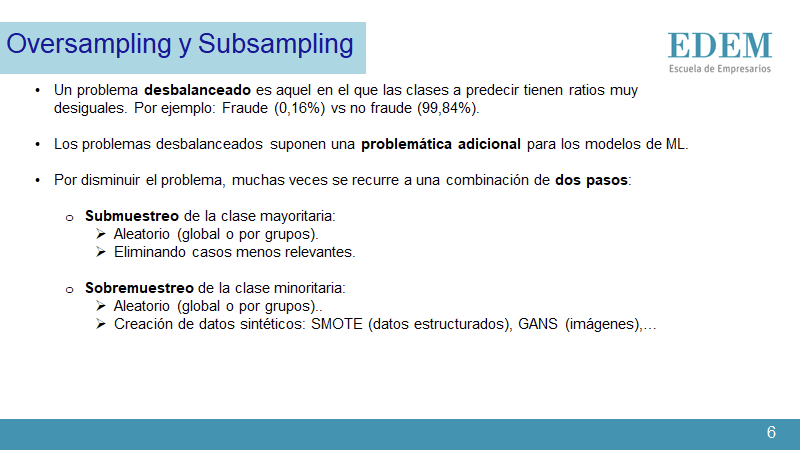

**Los problemas desequilibrados** son aquellos problemas de clasificación en los que la proporción entre las distintas clases es significativamente diferente. Estos problemas presentan algunas particularidades que los hacen un poco más difíciles de resolver. En particular, la elección de la métrica debe tener en cuenta este desequilibrio de clases, y deben llevarse a cabo algunos pasos adicionales para evitar que el modelo se centre demasiado en las clases más frecuentes y tenga un rendimiento deficiente en las menos frecuentes.

Nos centraremos en el problema de clasificación binaria, en el que hay una **clase mayoritaria** y una **clase minoritaria**. Por ejemplo, el problema de clasificación de la atención sanitaria en el que trabajamos en clases anteriores podría considerarse un problema desequilibrado, ya que la proporción de exitus (clase minoritaria) es aproximadamente del 5%. Otro ejemplo sería el problema de detección de fraude en Iberia Express, donde la clase minoritaria (transacción fraudulenta) nunca supera el 0,2% de los datos, ratio que se consideraría un verdadero problema de clasificación desequilibrado.

Las métricas que se pueden aplicar a problemas desequilibrados son las basadas en el área bajo una curva. Ya hemos visto la curva ROC y la curva precisión-recuerdo. De estas dos, el área bajo la curva de precisión-recuperación es ligeramente preferible cuando se trata de problemas muy desequilibrados.

En cuanto a los pasos de preprocesamiento adicionales que se pueden llevar a cabo para ayudar al modelo a resolver problemas desequilibrados, trataremos el **sobremuestreo** de la clase minoritaria y el **submuestreo** de la clase mayoritaria. Aquí nos centraremos en el submuestreo.

## Load Data

In [2]:
dat = pd.read_csv("../../datasets/i2.csv", sep = ";")
dat = dat.drop(['user', 'booking_date', 'origin_airport', 'airline'], axis = 1) # Remove non-numerical variables for this notebook
dat.head()

,price,sales channel,ant
0,NaN,online,NaN
1,147.500000,online,38.0
2,24.049999,online,19.0
3,59.709999,online,8.0
4,37.299999,call center,4.0


Imaginemos que queremos predecir el canal de ventas de una predicción concreta. Por lo tanto, nuestro valor objetivo es la columna *sales channel*. Como nos centramos en el caso de clasificación binaria, descartaremos las transacciones de las agencias de viajes.

In [3]:
dat = dat[dat['sales channel'] != 'travel agency']

In [4]:
100*dat.groupby(['sales channel'])['sales channel'].agg(['count'])/dat.shape[0]

,count
sales channel,
call center,5.882353
online,94.117647


Esto puede considerarse un problema de clasificación desequilibrada. Veamos cómo aplicarle el submuestreo.

## Subsampleo Aleatorio

Una forma sencilla de reducir los ejemplos de la clase mayoritaria es eliminar aleatoriamente los ejemplos de esta clase del conjunto de datos.

Esto se puede hacer fácilmente con la función *numpy.random.choice*.

In [5]:
?np.random.choice

Docstring:
choice(a, size=None, replace=True, p=None)

Generates a random sample from a given 1-D array

.. versionadded:: 1.7.0

.. note::
    New code should use the `~numpy.random.Generator.choice`
    method of a `~numpy.random.Generator` instance instead;
    please see the :ref:`random-quick-start`.

Parameters
----------
a : 1-D array-like or int
    If an ndarray, a random sample is generated from its elements.
    If an int, the random sample is generated as if it were ``np.arange(a)``
size : int or tuple of ints, optional
    Output shape.  If the given shape is, e.g., ``(m, n, k)``, then
    ``m * n * k`` samples are drawn.  Default is None, in which case a
    single value is returned.
replace : boolean, optional
    Whether the sample is with or without replacement. Default is True,
    meaning that a value of ``a`` can be selected multiple times.
p : 1-D array-like, optional
    The probabilities associated with each entry in a.
    If not given, the sample assumes a unif

In [6]:
subsampling_rows = np.random.choice(dat[dat['sales channel'] == 'online'].index, 
                                    int(0.5*dat.shape[0]),
                                   replace = False)
subsampling_rows

array([440, 907, 234, 868, 807, 834, 674, 984, 571, 139, 469, 679,  86,
       972, 467, 623, 616, 946, 886,  88, 653, 896, 716, 562, 789, 462,
       168, 850, 675, 866,  25, 693, 113, 795, 456, 729, 600, 339, 423,
       212,  35, 632, 115, 569, 517, 669, 188, 105, 169, 699,  56, 505,
       666, 684, 261, 114, 703, 998, 108, 382, 977, 581, 715, 647, 633,
       721, 506,  69, 427, 929, 871, 317, 399, 255,  44, 379, 776,  30,
       369, 100, 355, 855, 260,  90, 236, 931, 503,  39, 611, 555, 567,
       983, 800, 887, 366, 383, 533, 949, 819, 256,  51, 222, 854, 788,
       660, 253, 994, 959, 816,  63,  64, 740, 991, 470, 595, 973, 359,
       922, 719, 218, 771, 403, 224, 376, 190, 836, 176, 281, 412,   2,
       233, 912, 483, 661, 579, 448, 362, 664, 758, 903, 707, 391,   8,
       219, 321, 901, 676, 309, 979, 487, 199, 658, 441, 308,   0,  18,
       104, 950, 458, 621, 644, 432, 760, 332,  52, 331, 720, 775, 967,
       269, 730, 613, 672, 548, 486, 394,  95, 549, 102,  65, 23

In [7]:
dat_random_subsampling = dat.drop(subsampling_rows)

In [8]:
100*dat_random_subsampling.groupby(['sales channel'])['sales channel'].agg(['count'])/dat_random_subsampling.shape[0]

,count
sales channel,
call center,11.746988
online,88.253012


In [9]:
dat['sales channel'].value_counts()

online         624
call center     39
Name: sales channel, dtype: int64

In [10]:
dat_random_subsampling['sales channel'].value_counts()

online         293
call center     39
Name: sales channel, dtype: int64

Hemos reducido el desequilibrio en el target.

## Condensed Nearest Neighbors

Este método elimina instancias de la clase mayoritaria cumpliendo las siguientes condiciones:



- Obtener todas las muestras minoritarias en un conjunto C.


- Añadir una muestra de la clase objetivo (clase a submuestrear) en C y todas las demás muestras de esta clase en un conjunto S.


- Recorra el conjunto S, muestra por muestra, y clasifique cada muestra utilizando una regla de 1 vecino más cercano.


- Si la muestra está mal clasificada, añádala a C; de lo contrario, no haga nada.


- Repita la operación en S hasta que no quede ninguna muestra por añadir.


Está disponible en el paquete *imbalanced-learn* (ejecute pip install -U imbalanced-learn para instalarlo).

In [11]:
from imblearn.under_sampling import CondensedNearestNeighbour
?CondensedNearestNeighbour

Init signature:
CondensedNearestNeighbour(
    *,
    sampling_strategy='auto',
    random_state=None,
    n_neighbors=None,
    n_seeds_S=1,
    n_jobs=None,
)
Docstring:     
Undersample based on the condensed nearest neighbour method.

Read more in the :ref:`User Guide <condensed_nearest_neighbors>`.

Parameters
----------
sampling_strategy : str, list or callable
    Sampling information to sample the data set.

    - When ``str``, specify the class targeted by the resampling. Note the
      the number of samples will not be equal in each. Possible choices
      are:

        ``'majority'``: resample only the majority class;

        ``'not minority'``: resample all classes but the minority class;

        ``'not majority'``: resample all classes but the majority class;

        ``'all'``: resample all classes;

        ``'auto'``: equivalent to ``'not minority'``.

    - When ``list``, the list contains the classes targeted by the
      resampling.

    - When callable, function t

In [12]:
cnn = CondensedNearestNeighbour(sampling_strategy = 'majority', 
           n_jobs = cpu_count()-1)

In [13]:
X_cnn, y_cnn = cnn.fit_resample(dat.drop('sales channel', axis = 1).fillna(0), 
                                dat['sales channel'].fillna(0))

In [14]:
dat_cnn = pd.concat([X_cnn, y_cnn], axis = 1)

In [15]:
100*dat_cnn.groupby(['sales channel'])['sales channel'].agg(['count'])/dat_cnn.shape[0]

,count
sales channel,
call center,22.543353
online,77.456647


In [16]:
dat['sales channel'].value_counts()

online         624
call center     39
Name: sales channel, dtype: int64

In [17]:
dat_cnn['sales channel'].value_counts()

online         134
call center     39
Name: sales channel, dtype: int64

## Ejemplo

Trabajemos ahora con un conjunto de datos artificial.

In [18]:
?make_classification

Object `make_classification` not found.


In [19]:
from sklearn.datasets import make_classification

In [20]:
X, y = make_classification(n_samples=1000, weights=[0.99], flip_y=0, random_state=14)

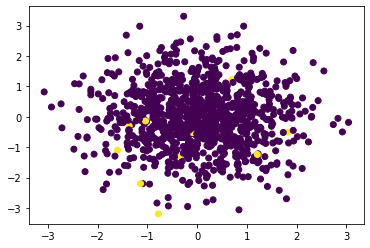

In [21]:
# scatter plot of examples by class label
plt.scatter(X[:, 0], X[:, 1], c = y)
plt.show()

In [22]:
unique, counts = np.unique(y, return_counts=True);
print(np.asarray((unique, counts)).T);

[[  0 990]
 [  1  10]]


Apliquemos Condensed Nearest Neighbors sobre este conjunto de datos.

In [34]:
cnn = CondensedNearestNeighbour(sampling_strategy = 'majority', 
                                n_neighbors = 1,
           n_jobs = cpu_count()-1)

In [35]:
X_cnn, y_cnn = cnn.fit_resample(X, y)

In [36]:
unique, counts = np.unique(y_cnn, return_counts=True);
print(np.asarray((unique, counts)).T);

[[ 0 83]
 [ 1 10]]


Y construyamos modelos con y sin sobremuestreo.

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.3, random_state=1);
X_cnn_train, X_cnn_test, y_cnn_train, y_cnn_test = train_test_split(X_cnn, y_cnn, stratify = y_cnn, test_size=0.3, random_state=1);


In [44]:
# 1) Import model
from sklearn.linear_model import LogisticRegression as model_constructor

# 2) Import metric
from sklearn.metrics import roc_auc_score as metric

# [3] Define model
model = model_constructor(penalty = 'l1', 
                          solver = 'liblinear', 
                          C = 1, 
                          random_state = 0)

# [4] Train model
model.fit(X_train, y_train) ## Only train!!! Requires target y for being supervised learning.

# [5] Predict
pred_train = model.predict_proba(X_train) 
pred_test = model.predict_proba(X_test) 

# [6] Compute metric
metric_train = metric(y_train, pred_train[:,1])
metric_test = metric(y_test, pred_test[:,1])

In [45]:
# 1) Import model
from sklearn.linear_model import LogisticRegression as model_constructor

# 2) Import metric
from sklearn.metrics import roc_auc_score as metric

# [3] Define model
model = model_constructor(penalty = 'l1', 
                          solver = 'liblinear', 
                          C = 1, 
                          random_state = 0)

# [4] Train model
model.fit(X_cnn_train, y_cnn_train) ## Only train!!! Requires target y for being supervised learning.

# [5] Predict
pred_train = model.predict_proba(X_cnn_train) 
pred_test = model.predict_proba(X_cnn_test) 

# [6] Compute metric
metric_cnn_train = metric(y_cnn_train, pred_train[:,1])
metric_cnn_test = metric(y_cnn_test, pred_test[:,1])

In [46]:
# print error
print('AUC train = %.2f - AUC test = %.2f' 
      % (metric_train, metric_test))

AUC train = 1.00 - AUC test = 0.63


In [47]:
# print error
print('AUC SMOTE train = %.2f - AUC SMOTE test = %.2f' 
      % (metric_cnn_train, metric_cnn_test))

AUC SMOTE train = 0.95 - AUC SMOTE test = 0.63


## Definir Función

Vamos a crear nuestra propia función personalizada para aplicar el submuestreo.

In [51]:
X_new, y_new = undersampling(X, y)
X_new.shape

(87, 20)

In [54]:
X_new, y_new = undersampling(X, y, p = 0.25, type_value = 'random')
X_new.shape

(258, 20)

## Otras Técnicas de Submuestreo

Hay variaciones de SMOTE disponibles en el paquete


- Submuestreo aleatorio mayoritario con sustitución


- Extracción de enlaces Tomek mayoritarios-minoritarios


- Submuestreo con centros de conglomerados


- NearMiss-(1 & 2 & 3)


- Selección unilateral


- Regla de limpieza de vecinos


- Vecinos más cercanos editados


- Umbral de dureza de la instancia


- Vecinos más próximos editados repetidamente


- TodoKNN






Referencia: https://github.com/scikit-learn-contrib/imbalanced-learn